In [2]:
from __future__ import print_function

In [3]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set(style='ticks', context='paper', rc={'font.sans-serif':'Arial', 'pdf.fonttype': 42})

%matplotlib inline

import flotilla


flotilla_dir = '/projects/ps-yeolab/obotvinnik/flotilla_projects'

study = flotilla.embark('singlecell_pnm_figure1_supplementary_post_splicing_filtering', flotilla_dir=flotilla_dir)

not_outliers = study.splicing.singles.index.difference(study.splicing.outliers.index)


/home/obotvinnik/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/obotvinnik/workspace-git/flotilla/flotilla/__init__.py:65: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  load_species_data=load_species_data)


2016-11-04 17:01:56	Reading datapackage from /projects/ps-yeolab/obotvinnik/flotilla_projects/singlecell_pnm_figure1_supplementary_post_splicing_filtering/datapackage.json
2016-11-04 17:01:56	Parsing datapackage to create a Study object
https://s3-us-west-2.amazonaws.com/flotilla-projects/ercc/ERCC_Controls.txt has not been downloaded before.
2016-11-04 17:02:18 	Initializing Study
2016-11-04 17:02:18 	Initializing Predictor configuration manager for Study
2016-11-04 17:02:18	Predictor ExtraTreesClassifier is of type <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
2016-11-04 17:02:18	Added ExtraTreesClassifier to default predictors
2016-11-04 17:02:18	Predictor ExtraTreesRegressor is of type <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
2016-11-04 17:02:18	Added ExtraTreesRegressor to default predictors
2016-11-04 17:02:18	Predictor GradientBoostingClassifier is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
2016-11-04 17:02:18	Added Grad

Error loading species hg19 data: HTTP Error 404: Not Found

In [4]:
folder = 'figures/011_modality_calculation_different_cell_detection_cutoffs' #'/home/obotvinnik/Dropbox/figures2/singlecell_pnm/figure2_modalities/bayesian'
! mkdir $folder

mkdir: cannot create directory `figures/011_modality_calculation_different_cell_detection_cutoffs': File exists


In [5]:
singles_no_outliers = study.splicing.singles.ix[not_outliers].index
print(singles_no_outliers.shape)

(181,)


In [6]:
splicing_singles_no_outliers = study.splicing.data.loc[singles_no_outliers]
print(splicing_singles_no_outliers.shape)
splicing_singles_no_outliers.head()

(181, 16360)


,exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-,exon:chr10:100193697-100193848:-@exon:chr10:100190888-100191048:-@exon:chr10:100190328-100190427:-,exon:chr10:100195392-100195529:-@exon:chr10:100195029-100195171:-@exon:chr10:100193697-100193848:-,exon:chr10:101165513-101165617:-@exon:chr10:101163481-101163631:-@exon:chr10:101163226-101163391:-,exon:chr10:101480744-101480825:-@exon:chr10:101478103-101478257:-@exon:chr10:101476105-101476218:-,exon:chr10:101507014-101507147:+@exon:chr10:101510126-101510153:+@exon:chr10:101514286-101514391:+,exon:chr10:101507014-101507147:+@exon:chr10:101514286-101514391:+@exon:chr10:101515382-101515465:+,exon:chr10:101964263-101964414:-@exon:chr10:101961845-101961906:-@exon:chr10:101960428-101960537:-,exon:chr10:101969352-101969546:-@exon:chr10:101966987-101967089:-@exon:chr10:101964833-101964956:-,exon:chr10:101997779-101997988:-@exon:chr10:101996607-101996726:-@exon:chr10:101995424-101995521:-,...,exon:chrY:21903204-21903374:-@exon:chrY:21901414-21901548:-@exon:chrY:21897507-21897636:-,exon:chrY:21903621-21903743:-@exon:chrY:21903204-21903374:-@exon:chrY:21901414-21901548:-,exon:chrY:22744476-22744579:+@exon:chrY:22746360-22746410:+@exon:chrY:22749910-22749991:+,exon:chrY:2709527-2709668:+@exon:chrY:2710206-2710283:+@exon:chrY:2712118-2712298:+,exon:chrY:2710206-2710283:+@exon:chrY:2712118-2712298:+@exon:chrY:2713687-2713784:+,exon:chrY:2712118-2712298:+@exon:chrY:2713687-2713784:+@exon:chrY:2722641-2722812:+,exon:chrY:2713687-2713784:+@exon:chrY:2722641-2722812:+@exon:chrY:2733129-2733286:+,exon:chrY:2722641-2722812:+@exon:chrY:2733129-2733286:+@exon:chrY:2734834-2734903:+,exon:chrY:2821950-2822038:+@exon:chrY:2829115-2829687:+@exon:chrY:2843136-2843285:+,exon:chrY:2843552-2843695:+@exon:chrY:2844711-2844863:+@exon:chrY:2845981-2846121:+
CVN_01,NaN,NaN,NaN,1,NaN,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1,1,1,1,1,NaN,NaN
CVN_02,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CVN_03,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CVN_04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,...,NaN,NaN,NaN,1,1,1,1,1,NaN,NaN
CVN_05,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1,1,1,1,1,1,NaN,NaN


## Estimate modalities

### Initialize the modality estimator

In [7]:
import anchor

bayesian = anchor.BayesianModalities()
# binned = anchor.BinnedModalities()
# monte_carlo = anchor.MonteCarloModalities()

## Calculate/Estimate modalities only on single cells, with no outliers

And at least 10 cells per splicing event, per celltype/phenotype

In [8]:
from anchor import MODALITY_ORDER, MODALITY_PALETTE, MODALITY_TO_COLOR

def tidify_modalities(modality_assignments, name='event_id'):
    modalities_tidy = modality_assignments.stack().reset_index()
    modalities_tidy = modalities_tidy.rename(columns={'level_1': name, 0: "modality"})
    return modalities_tidy

def count_modalities(tidy_modalities, name='event_id'):
    modalities_counts = tidy_modalities.groupby(['phenotype', 'modality']).count().reset_index()
    modalities_counts = modalities_counts.rename(columns={name: '# AS events'})
    modalities_counts['percentage'] = 100*modalities_counts.groupby('phenotype')['# AS events'].apply(lambda x: x/x.sum())
    return modalities_counts

def count_modalities_2d(modality_counts, index='phenotype'):
    modalities_counts_2d = modality_counts.pivot(index=index, columns='modality', values='# AS events')
    modalities_counts_2d = modalities_counts_2d.reindex(columns=MODALITY_ORDER, index=study.phenotype_order)
    modalities_counts_2d = modalities_counts_2d.T
    return modalities_counts_2d

## Do simulations across multiple minimum sample cutoffs

In [9]:
%%time

thresholds = np.arange(0.05, 1, 0.05)

dfs = []

for threshold in thresholds:
    print(threshold)
#     min_samples 
    
    splicing_2d_min_samples = splicing_singles_no_outliers.groupby(
        study.sample_id_to_phenotype).apply(lambda x: x.dropna(thresh=np.round(threshold*x.shape[0]), axis=1))
    print('\tsplicing_2d_min_samples.shape', splicing_2d_min_samples.shape)
    splicing_2d_min_samples.head()
    
    %time modality_assignments = splicing_2d_min_samples.groupby(study.sample_id_to_phenotype).apply(bayesian.fit_predict)
    
    tidy = tidify_modalities(modality_assignments)
    counts = count_modalities(tidy)
    counts['threshold'] = threshold
    dfs.append(counts)
modalities_cutoffs = pd.concat(dfs, ignore_index=True)
print(modalities_cutoffs.shape)
modalities_cutoffs.head()
#     counts_2d = count_modalities_2d(counts)

0.05
	splicing_2d_min_samples.shape (181, 16360)
CPU times: user 20min 43s, sys: 208 ms, total: 20min 43s
Wall time: 20min 42s
0.1
	splicing_2d_min_samples.shape (181, 15525)
CPU times: user 15min 38s, sys: 124 ms, total: 15min 38s
Wall time: 15min 37s
0.15
	splicing_2d_min_samples.shape (181, 13568)
CPU times: user 13min 6s, sys: 87 ms, total: 13min 6s
Wall time: 13min 5s
0.2
	splicing_2d_min_samples.shape (181, 11665)
CPU times: user 10min 28s, sys: 110 ms, total: 10min 28s
Wall time: 10min 28s
0.25
	splicing_2d_min_samples.shape (181, 10471)
CPU times: user 8min 33s, sys: 139 ms, total: 8min 34s
Wall time: 8min 33s
0.3
	splicing_2d_min_samples.shape (181, 9233)
CPU times: user 7min 10s, sys: 60 ms, total: 7min 10s
Wall time: 7min 10s
0.35
	splicing_2d_min_samples.shape (181, 8215)
CPU times: user 6min 1s, sys: 47 ms, total: 6min 1s
Wall time: 6min 1s
0.4
	splicing_2d_min_samples.shape (181, 7382)
CPU times: user 5min 9s, sys: 77 ms, total: 5min 9s
Wall time: 5min 9s
0.45
	splicing_2

TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

In [10]:
modalities_cutoffs = pd.concat(dfs, ignore_index=True)
print(modalities_cutoffs.shape)
modalities_cutoffs.head()

(246, 5)


,phenotype,modality,# AS events,percentage,threshold
0,MN,bimodal,2714,23.510049,0.05
1,MN,excluded,2167,18.771656,0.05
2,MN,included,5275,45.694733,0.05
3,MN,uncategorized,1388,12.023562,0.05
4,NPC,bimodal,4182,28.901175,0.05


In [25]:
sns.set(context='paper', style='whitegrid') 

In [26]:
modalities_cutoffs = modalities_cutoffs.rename(columns={'percentage': '% of AS events'})

In [27]:
modalities_cutoffs['% of cells'] = modalities_cutoffs['threshold'] * 100

In [28]:
folder

'figures/011_modality_calculation_different_cell_detection_cutoffs'

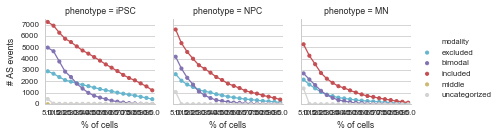

In [37]:
facetgrid = sns.factorplot(x='% of cells', y='# AS events', data=modalities_cutoffs, 
               hue='modality', hue_order=MODALITY_ORDER, palette=MODALITY_PALETTE,
               col='phenotype', col_order=study.phenotype_order, size=2, scale=0.5)
facetgrid.set(ylim=(0, 7500))
facetgrid.savefig('{}/cell_cutoff_vs_number_of_events_per_modality.pdf'.format(folder))

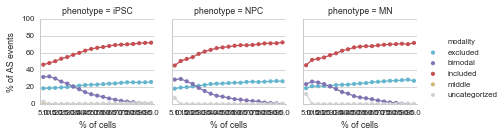

In [35]:
facetgrid = sns.factorplot(x='% of cells', y='% of AS events', data=modalities_cutoffs, 
               hue='modality', hue_order=MODALITY_ORDER, palette=MODALITY_PALETTE,
               col='phenotype', col_order=study.phenotype_order, size=2, scale=0.5)
facetgrid.set(ylim=(0, 100))
facetgrid.savefig('{}/cell_cutoff_vs_percentage_of_per_modality.pdf'.format(folder))

In [31]:
n_events_per_cutoff = modalities_cutoffs.groupby(['% of cells', 'phenotype'])['# AS events'].sum().reset_index()
n_events_per_cutoff.head()

,% of cells,phenotype,# AS events
0,5,MN,11544
1,5,NPC,14470
2,5,iPSC,15591
3,10,MN,8198
4,10,NPC,10595


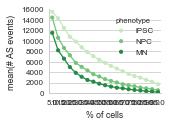

In [34]:
fig, ax = plt.subplots(figsize=(2, 1.5))
sns.pointplot(x='% of cells', y='# AS events', hue='phenotype', data=n_events_per_cutoff, 
              palette=study.phenotype_to_color, scale=0.5, hue_order=study.phenotype_order)
sns.despine()
ax.set(ylim=(0, 16000))
fig.savefig('{}/number_of_events_per_cutoff.pdf'.format(folder))

In [22]:
study.supplemental.modalities_cell_thresholds = modalities_cutoffs
study.save('singlecell_pnm_figure2_modalities_cell_thresholds', flotilla_dir=flotilla_dir)

Wrote datapackage to /projects/ps-yeolab/obotvinnik/flotilla_projects/singlecell_pnm_figure2_modalities_cell_thresholds/datapackage.json
